In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.optim.lr_scheduler import _LRScheduler

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary

from sklearn import manifold
from torchvision.datasets import VisionDataset, Flickr30k
from collections import Counter
import pickle
from tqdm import tqdm
import nltk
from collections import defaultdict
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.corpus import stopwords


In [74]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [75]:
!pip install --user -U nltk

Requirement already up-to-date: nltk in /home/ar7996/.local/lib/python3.8/site-packages (3.8.1)
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [76]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [77]:
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/ar7996/.local/lib/python3.8/site-packages (1.2.2)
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [78]:
!pip3 install torch torchvision

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
training_data = Flickr30k('flickr30k-images', 'results_20130124.token')

In [4]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.all_words = []

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
            self.all_words.append(word)
            
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

    def get_id(self, w):
        return self.word2idx[w]

    def encode_seq(self, l):
        return [self.word2idx[i] if i in self.word2idx else self.word2idx['<unk>'] for i in l]

    def get_token(self, idx):
        return self.idx2word[idx]

    def decode_seq(self, l):
        return [self.idx2word[i] for i in l] 

In [37]:
def get_splits(filepath = 'flickr30k-images', size = 256, seed = 2020):
    np.random.seed(seed)
    train_set = set()
    val_set = set()
    test_set = set()
    
    for filename in tqdm(os.listdir(filepath)):
        if filename[-3:] == 'jpg':
            img = np.array(Image.open(os.path.join(filepath, filename)))
            if img.shape[0] >= size and img.shape[1] >= size:
                selector = np.random.multinomial(size=1, n=1, pvals = [0.8, 0.1, 0.1])
                if selector[0][0] == 1:
                    train_set.add(filename)
                elif selector[0][1] == 1: 
                    val_set.add(filename)
                else:
                    test_set.add(filename)
            
    pickle.dump(train_set,open('train_set.p', 'wb'))
    pickle.dump(val_set,open('val_set.p', 'wb'))
    pickle.dump(test_set,open('test_set.p', 'wb'))

get_splits()


100%|██████████| 31784/31784 [06:04<00:00, 87.16it/s] 


In [5]:
def build_vocab(ann_file = 'results_20130124.token', threshold = 3):
    punc_set = set([',',';',':','.','?','!','(',')','``','"'])
    counter = Counter()
    caption_list = []
    split = pickle.load(open('train_set.p', 'rb'))
    ann_file = os.path.expanduser(ann_file)
    with open(ann_file) as fh:
        for line in fh:
            img, caption = line.strip().split('\t')
            if img[:-2] in split:
                caption_list.append(caption)
    for caption in tqdm(caption_list):
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        tokens = [elem for elem in tokens if elem not in punc_set] 
        counter.update(tokens)

    words = [word for word, cnt in counter.items() if cnt >= threshold]

    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')
    vocab.add_word('<break>')

    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ar7996/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
vocab = build_vocab()
pickle.dump(vocab,open('vocab.p', 'wb'))

100%|██████████| 126330/126330 [00:14<00:00, 8909.23it/s]


In [8]:
class Custom_Flickr30k(VisionDataset):

    def __init__(self, root, ann_file, vocabulary, train=True, transform=None, target_transform=None, test=False):
        super(Custom_Flickr30k, self).__init__(root, transform=transform, target_transform=target_transform)
        self.ann_file = os.path.expanduser(ann_file)
        self.train = train
        self.test = test
        self.annotations = defaultdict(list)
        self.punc_set = set([',',';',':','.','?','!','(',')'])
        
        if self.train:
            split = pickle.load(open('train_set.p', 'rb'))
            idx=0
            with open(self.ann_file) as fh:
                for line in fh:
                    img_id, caption = line.strip().split('\t')
                    img = img_id[:-2]
                    if img in split:
                        self.annotations[idx].extend([img,caption])
                        idx += 1
            self.ids = np.arange(idx-1)
        elif self.test:
            split = pickle.load(open('test_set.p', 'rb'))
            idx=0
            with open(self.ann_file) as fh:
                for line in fh:
                    img_id, caption = line.strip().split('\t')
                    img = img_id[:-2]
                    if img in split:
                        self.annotations[idx].extend([img,caption])
                        idx += 1
            self.ids = np.arange(idx-1)
        else:
            split = pickle.load(open('val_set.p', 'rb'))
            idx = -1
            last_image = ''
            with open(self.ann_file) as fh:
                for line in fh:
                    img_id, caption = line.strip().split('\t')
                    img = img_id[:-2]
                    if img in split:
                        if img != last_image:
                            idx += 1
                            last_image = img
                            self.annotations[idx].append(img)
                            self.annotations[idx].append([caption])
                        else:
                            self.annotations[idx][1].append(caption)
            self.ids = np.arange(idx)

    def __getitem__(self, index):
        
        instance = self.annotations[index]
        
        img_id = instance[0]
        caption = instance[1]
        
        # Image
        filename = os.path.join(self.root, img_id)
        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        if self.train or self.test:

            # Captions
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(vocab('<start>'))
            caption.extend([vocab(token) for token in tokens if token not in self.punc_set])
            caption.append(vocab('<end>'))
            target = torch.Tensor(caption)
            
        else:
            # Captions
            target = []
            for item in caption:
                tokens = nltk.tokenize.word_tokenize(str(item).lower())
                target.extend([vocab(token) for token in tokens if token not in self.punc_set])
                target.append(vocab('<break>'))
            
            target = torch.Tensor(target[:-1])

        return img, target


    def __len__(self):
        return len(self.ids)

In [9]:
def collate_fn(data):

    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [10]:
batch_size = 128
num_workers = 4
crop_size = 256
transform = transforms.Compose([
            transforms.RandomCrop(crop_size),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize((0.444, 0.421, 0.385), 
                                 (0.285, 0.277, 0.286))])

In [11]:
flickr_data = Custom_Flickr30k('flickr30k-images', 'results_20130124.token', vocab, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=flickr_data, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers,
                                          collate_fn=collate_fn)

# Model

In [12]:
class SimpleEncoderCNN(nn.Module):
    def __init__(self, embed_size, fine_tune=False):
        super(SimpleEncoderCNN, self).__init__()
        self.fine_tune = fine_tune
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.1)

    def forward(self, images):
        if self.fine_tune:
            features = self.resnet(images)
        else:
            with torch.no_grad():
                features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

In [13]:
class SimpleDecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(SimpleDecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None, max_seq_length=20):
        #Gready Search
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(max_seq_length):
            hiddens, states = self.lstm(inputs, states)          
            outputs = self.linear(hiddens.squeeze(1))            
            _, predicted = outputs.max(1)                        
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       
            inputs = inputs.unsqueeze(1)                         
        sampled_ids = torch.stack(sampled_ids, 1)                
        return sampled_ids

In [14]:
crop_size=256
val_transform = transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize((0.444, 0.421, 0.385),
                                 (0.285, 0.277, 0.286))])
val_loader = torch.utils.data.DataLoader(
            dataset=Custom_Flickr30k('flickr30k-images','results_20130124.token', vocab, transform=val_transform, train=False),
            batch_size=16,
            shuffle=False,
            num_workers=2,
            collate_fn=collate_fn)

In [15]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 1e-3
num_epoch = 10
fine_tune = False
max_BLEU = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = SimpleEncoderCNN(embed_size, fine_tune).to(device)
decoder = SimpleDecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

criterion = torch.nn.CrossEntropyLoss()
if fine_tune:
    params = list(encoder.parameters()) + list(decoder.parameters())
else:
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.RMSprop(params, lr=learning_rate, alpha=0.99, eps=1e-08)

/home/ar7996/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ar7996/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
def bleu_eval(encoder, decoder, data_loader, batch_size, device):
    
    with torch.no_grad():
        features = None
        imgs = None
        caps = None
        encoder.to(device)
        decoder.to(device)
        for i, (images, captions, lengths) in enumerate(data_loader):
            features = encoder(images.to(device))
            imgs = images
            caps = captions
            results = decoder.sample(features)
            true_outputs=[]

            for caption in captions:
                caption = caption.cpu().numpy().astype(str).tolist()
                idx = 0
                curr_img_captions = [[]] 
                for tok in caption[1:-1]:
                    if tok == '4': # '<break>'
                        idx += 1
                        curr_img_captions.append([])
                    elif tok != '0': # '<pad>'
                        curr_img_captions[idx].append(vocab.idx2word[int(tok)])
                true_outputs.append(curr_img_captions)

            predictions = []
            for pred in results:
                curr = []
                for tok in pred:
                    if tok == '2': # '<end>'
                        break
                    curr.append(vocab.idx2word[int(tok)])
                predicted_caption = []
                for token_index in curr:
                    if token_index == '<end>':
                        break
                    elif token_index == '<start>':
                        continue
                    predicted_caption.append(token_index)
                predictions.append(predicted_caption)

        return nltk.bleu_score.corpus_bleu(true_outputs, predictions, weights=(0.5, 0.5, 0, 0))

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loss = []
bleu_score = []

print(device)
for epoch in range(num_epoch):
    epoch_loss = 0
    for i, (images, captions, lengths) in tqdm(enumerate(data_loader)):
        
        #Train
        encoder.train()
        decoder.train()

        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        features = encoder(images)
        features.to(device)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_loss = epoch_loss/1110
    train_loss.append(epoch_loss)
    
    #Eval
    encoder.eval()
    decoder.eval()
    
    score = bleu_eval(encoder, decoder, val_loader, 16, device)
    bleu_score.append(score)
    is_best = score > max_BLEU
    max_BLEU = max(score, max_BLEU)

    if is_best:
        torch.save(encoder, 'encoder_rmsprop_1.pt')
        torch.save(decoder, 'decoder_rmsprop_1.pt')

        
    print('Epoch [{}/{}], Loss: {:.4f}'
              .format(epoch+1, num_epoch, epoch_loss))
    print("Validation Bleu Score: ", score)

cuda


987it [09:51,  1.67it/s]


Epoch [1/10], Loss: 2.8135
Validation Bleu Score:  0.36192975932483296


987it [10:23,  1.58it/s]


Epoch [2/10], Loss: 2.4964
Validation Bleu Score:  0.3997950294510557


987it [11:44,  1.40it/s]


Epoch [3/10], Loss: 2.3335
Validation Bleu Score:  0.26144621016938546


/home/ar7996/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
987it [11:44,  1.40it/s]


Epoch [4/10], Loss: 2.2159
Validation Bleu Score:  0.30181300682888257


987it [11:45,  1.40it/s]


Epoch [5/10], Loss: 2.1201
Validation Bleu Score:  0.32844590472217355


987it [11:44,  1.40it/s]


Epoch [6/10], Loss: 2.0362
Validation Bleu Score:  0.28667735879552303


987it [11:44,  1.40it/s]


Epoch [7/10], Loss: 1.9628
Validation Bleu Score:  0.2714483570153185


987it [11:44,  1.40it/s]


Epoch [8/10], Loss: 1.8962
Validation Bleu Score:  0.3938299643454349


987it [11:44,  1.40it/s]


Epoch [9/10], Loss: 1.8355
Validation Bleu Score:  0.35476358393170254


987it [11:44,  1.40it/s]


Epoch [10/10], Loss: 1.7805
Validation Bleu Score:  0.37835259339868


## Testing Loss Graph Plot

Text(0, 0.5, 'Testing Loss')

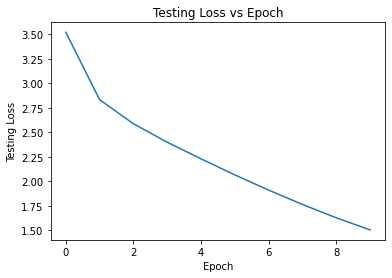

In [31]:
plt.title('Testing Loss vs Epoch')
plt.plot(train_loss)
plt.xlabel("Epoch")
plt.ylabel("Testing Loss")

# Model Testing

In [20]:
encoder = torch.load('encoder_rmsprop_1.pt')
decoder = torch.load('decoder_rmsprop_1.pt')

In [42]:
vocab = pickle.load(open('vocab.p', 'rb'))

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
test_transform = transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize((0.444, 0.421, 0.385),
                                 (0.285, 0.277, 0.286))])

test_loader = torch.utils.data.DataLoader(
            dataset=Custom_Flickr30k('flickr30k-images','results_20130124.token', vocab, transform=test_transform, train=False, test=True),
            batch_size=16,
            shuffle=True,
            num_workers=2,
            collate_fn=collate_fn)

In [22]:
encoder.to(device)
decoder.to(device)
for i, (images, captions, lengths) in enumerate(test_loader):
    if i == 1:
        break
    features = encoder(images.to(device))
    imgs = images
    caps = captions
    results = decoder.sample(features)
    true_outputs=[]

    for caption in captions:
        caption = caption.cpu().numpy().astype(str).tolist()
        idx = 0
        curr_img_captions = [[]]
        for tok in caption[1:-1]:
            if tok == '4': # '<break>'
                idx += 1
                curr_img_captions.append([])
            elif tok != '0': # '<pad>'
                curr_img_captions[idx].append(vocab.idx2word[int(tok)])
        true_outputs.append(curr_img_captions)

    predictions = []
    for pred in results:
        curr = []
        for tok in pred:
            if tok == '2': # '<end>'
                break
            curr.append(vocab.idx2word[int(tok)])
        predicted_caption = []
        for token_index in curr:
            if token_index == '<end>':
                break
            elif token_index == '<start>':
                continue
            predicted_caption.append(token_index)
        predictions.append(predicted_caption)
        
    print("Bleu Score: ", nltk.bleu_score.corpus_bleu(true_outputs, predictions, weights=(0.5, 0.5, 0, 0)))
    
    

Bleu Score:  0.125118539618862


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


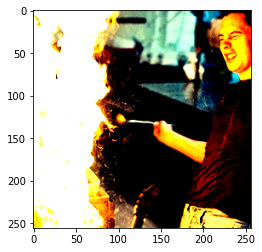

In [23]:
img = np.transpose(imgs[1], (1, 2, 0))
plt.imshow(img)

In [25]:
print(predictions[1])

['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'cutting', 'wood']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


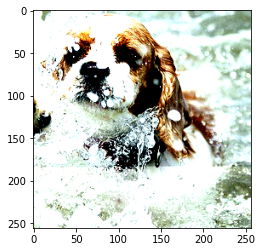

In [26]:
img = np.transpose(imgs[4], (1, 2, 0))
plt.imshow(img)

In [32]:
print(predictions[4])

['a', 'dog', 'is', 'running', 'through', 'the', 'water']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


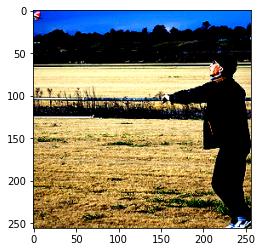

In [37]:
img = np.transpose(imgs[11], (1, 2, 0))
plt.imshow(img)

In [38]:
print(predictions[11])

['a', 'man', 'in', 'a', 'green', 'shirt', 'and', 'black', 'pants', 'is', 'walking', 'on', 'a', 'grassy', 'hill']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


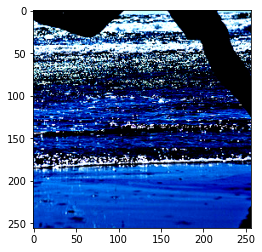

In [35]:
img = np.transpose(imgs[9], (1, 2, 0))
plt.imshow(img)

In [36]:
print(predictions[9])

['a', 'man', 'is', 'surfing', 'on', 'a', 'surfboard']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


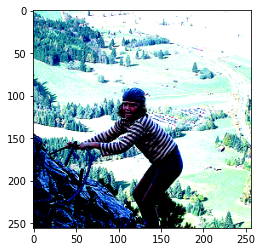

In [39]:
img = np.transpose(imgs[13], (1, 2, 0))
plt.imshow(img)

In [40]:
print(predictions[13])

['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'climbing', 'a', 'cliff']
